In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import sys
import math
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.stats import gaussian_kde
from scipy.stats import kde
from astropy.io import fits
from matplotlib.colors import LogNorm
from collections import defaultdict
import time
from matplotlib.lines import Line2D
%matplotlib inline

# load and run with rob's fixed sims 3-24-20
### objects with cut = -1 have snr > 5 and redshift consistent with ligo distance at 3 sigma

Load in rob's data -- already a nested dictionary where keys are the snid and have dictionaries 'lightcurve' and 'metadata'

In [ ]:
data_Ia = np.load('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/cut_results/rmorgan_DESGW_GW190510_Ia_cut_results.npy').item()
data_CC = np.load('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/cut_results/rmorgan_DESGW_GW190510_CC_cut_results.npy').item()
data_KN = np.load('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/cut_results/rmorgan_DESGW_GW190510_KN_cut_results.npy').item()


Define functions for sorting colors, kns, and making contours

In [5]:
def get_color_mag_data(d, mag, color1, color2):
    """
    Extract color and mag info from a '*_cut_results' dictionary
    
    :param d: the cut_results dictionary
    :param mag: from ['g', 'r', 'i', 'z'], the band you want the magnitude for
    :param color1: from ['g', 'r', 'i', 'z'], the first band you want the color for
    :param color2: from ['g', 'r', 'i', 'z'], the second band you want the color for
        -- returned color is color1 - color2
    :return: dataframe: a pandas dataframe with columns SNID, MAG, MAGERR, COLOR, and COLORERR
    """
    
    data = []
    data_cols = ['SNID', 'MAG', 'COLOR', 'MAGERR', 'COLORERR']
    
    for snid, info in d.iteritems():
        if int(info['cut']) == -1:
            if not (color1 in np.unique(info['lightcurve']['FLT'].values) and (color2 in np.unique(info['lightcurve']['FLT'].values))):
                continue
            
            #Select needed filters from dataframe
            mag_data = info['lightcurve'][info['lightcurve']['FLT'].values == mag].copy().reset_index(drop=True)
            color1_data = info['lightcurve'][info['lightcurve']['FLT'].values == color1].copy().reset_index(drop=True)
            color2_data = info['lightcurve'][info['lightcurve']['FLT'].values == color2].copy().reset_index(drop=True)

            #Get mag and magerr
            brightest_mag_index = np.argmin(np.array(mag_data['MAG'].values, dtype=float))
            ap_mag = float(mag_data['MAG'].values[brightest_mag_index])
            ap_magerr = float(mag_data['MAGERR'].values[brightest_mag_index])

            #Get color and colorerr
            brightest_color1_index = np.argmin(np.array(color1_data['MAG'].values, dtype=float))
            color1_mag = float(color1_data['MAG'].values[brightest_color1_index])
            color1_magerr = float(color1_data['MAGERR'].values[brightest_color1_index])

            brightest_color2_index = np.argmin(np.array(color2_data['MAG'].values, dtype=float))
            color2_mag = float(color2_data['MAG'].values[brightest_color2_index])
            color2_magerr = float(color2_data['MAGERR'].values[brightest_color2_index])

            ap_color = color1_mag - color2_mag
            ap_color_err = np.sqrt(color1_magerr**2 + color2_magerr**2)
            
            if ap_mag < 27.5 and np.abs(ap_color) < 20:
                #only keep if values are sensible
                ## - this will throw out objects where MAG = 99.0 due it being fainter than 27.5
                data.append([snid, ap_mag, ap_color, ap_magerr, ap_color_err])
            
    return pd.DataFrame(data=data, columns=data_cols)

#Example
#ia_data = np.load('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/cut_results/rmorgan_DESGW_GW190510_Ia_cut_results.npy').item()
#ia_g_gr = get_color_mag_data(ia_data, 'g', 'g', 'r')

In [6]:
def get_170817_like(fullkndict, sorteddf):
    """
    fullkndict: full kn sim dictionary e.g. data_KN = np.load('/data/des60.b/data/rmorgan/DES_Followups/events/GW190510/cut_results/rmorgan_DESGW_GW190510_KN_cut_results.npy').item()
    sorteddf: df with snid, mag, color as columns e.g. KN_g_gr = get_color_mag_data(data_KN, 'g', 'g', 'r')
    
    returns two lists with mags and colors of sims with 170817 like parameters
    """
    
    kn_mag_170817 = []
    kn_color_170817 = []
    
    for idx, row in sorteddf.iterrows():
        velocity = fullkndict[row['SNID']]['metadata']['SIMSED_param(VK)']
        logmass = fullkndict[row['SNID']]['metadata']['SIMSED_param(LOGMASS)']
        logXlan = fullkndict[row['SNID']]['metadata']['SIMSED_param(LOGXLAN)']
        
        if round(velocity,3)==0.3 and logXlan==-4.0 and round(10**logmass,4)==0.025:
            kn_mag_170817.append(row['MAG'])
            kn_color_170817.append(row['COLOR'])
    
    return kn_mag_170817, kn_color_170817

In [ ]:
def make_contours_kde(mags, colors, ax, contcolor='b', levels=[0., 0.50, 0.90]):
    """
    mags: list of magnitudes. ex: Ia_g_gr['MAG'].values
    colors: list of colors. ex: Ia_g_gr['COLOR'].values
    levels: list of contour levels. ex: levels = [0., 0.50, 0.90, 0.99]. NEED 0. 
        default to 50 and 90% contours.
    ax: axis, assuming this is being mad in a plt.figure
    """
    
    allSNgr_2darray = np.asarray([mags, colors])
    allSNx, allSNy = allSNgr_2darray

    allSNk = gaussian_kde(allSNgr_2darray)
    allSNxi, allSNyi = np.mgrid[allSNx.min():allSNx.max():allSNx.size**0.5*1j,allSNy.min():allSNy.max():allSNy.size**0.5*1j]
    allSNzi = allSNk(np.vstack([allSNxi.flatten(), allSNyi.flatten()]))

    allSNzi = 1 - (allSNzi-allSNzi.min())/(allSNzi.max() - allSNzi.min())
    allSNzi =allSNzi.reshape(allSNxi.shape)

    origin = 'lower'
    levels = levels

    SNCS = ax.contour(allSNxi, allSNyi, allSNzi,levels = levels,
                  colors=[contcolor],
                  linewidths=(1,),
                  origin=origin, alpha=0.5)
    return SNCS

## load in real candidate data from my google sheet

In [ ]:
raw_man_data = pd.read_csv('realcands_manual.csv') #load in data
new = raw_man_data[['gcn des name', 'BAND', 'flux', 'flux err', 'MAG']] #pull columns I care about
new.drop(new.tail(3).index,inplace=True) #remove extranneous rows
new.fillna(method='ffill', inplace=True) #fill in 'gcn des name' column so that we can group other cols by name
newgrouped = new.groupby('gcn des name') #group

Make dictionary: {name: {mag: mag, color: color}}  
dictionaries already sorted -- name appropriately

In [ ]:
real_g_gr = {}
real_g_gz = {}
real_r_rz = {}

for key, val in newgrouped:
    if 'g' in val['BAND'].values and 'r' in val['BAND'].values:
        gidx = val.index[val['BAND'] == 'g'].values[0]
        ridx = val.index[val['BAND'] == 'r'].values[0]
        color = val['MAG'][gidx] - val['MAG'][ridx]
        real_g_gr[key] = {'mag':val['MAG'][gidx], 'color':color}
        
    if 'g' in val['BAND'].values and 'z' in val['BAND'].values:
        gidx = val.index[val['BAND'] == 'g'].values[0]
        zidx = val.index[val['BAND'] == 'z'].values[0]
        color = val['MAG'][gidx] - val['MAG'][zidx]
        real_g_gz[key] = {'mag':val['MAG'][gidx], 'color':color}
        
    if 'r' in val['BAND'].values and 'z' in val['BAND'].values:
        ridx = val.index[val['BAND'] == 'r'].values[0]
        zidx = val.index[val['BAND'] == 'z'].values[0]
        color = val['MAG'][ridx] - val['MAG'][zidx]
        real_r_rz[key] = {'mag':val['MAG'][ridx], 'color':color}


### Test if data is correct

In [7]:
Ia_g_gr = get_color_mag_data(data_Ia, 'g', 'g', 'r')
CC_g_gr = get_color_mag_data(data_CC, 'g', 'g', 'r')
KN_g_gr = get_color_mag_data(data_KN, 'g', 'g', 'r')

In [8]:
print len(Ia_g_gr)
print len(CC_g_gr)
print len(KN_g_gr)

2588
2586
43862


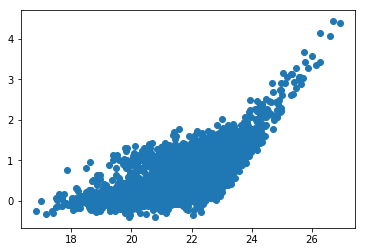

In [14]:
plt.scatter(Ia_g_gr.MAG, Ia_g_gr.COLOR)

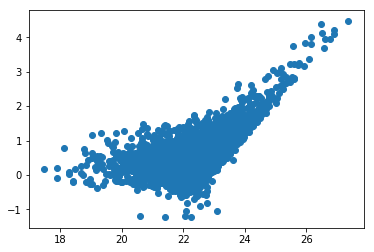

In [21]:
#plt.scatter(CC_g_gr.MAG, Ia_g_gr.COLOR)
col = CC_g_gr['COLOR'].values
mag = CC_g_gr['MAG'].values
plt.scatter(mag, col)

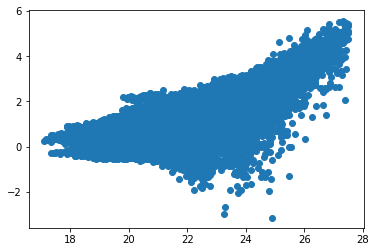

In [22]:
col = KN_g_gr['COLOR'].values
mag = KN_g_gr['MAG'].values
plt.scatter(mag, col)

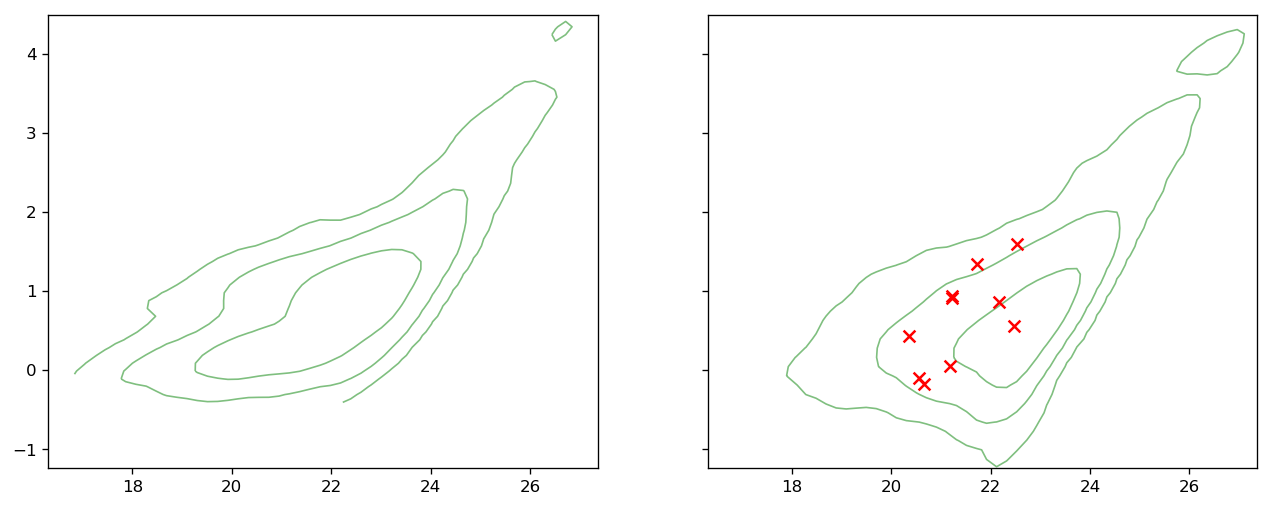

In [31]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13, 5), dpi=120)

make_contours_kde(Ia_g_gr['MAG'].values, Ia_g_gr['COLOR'].values, ax[0], levels=[0., 0.50, 0.90, 0.99])
make_contours_kde(CC_g_gr['MAG'].values, CC_g_gr['COLOR'].values, ax[1], levels=[0., 0.50, 0.90, 0.99])

for k in range(len(real_color)):
    ax[1].scatter(float(real_apparent_mag[k]), float(real_color[k]), 
               c='r', marker='x', zorder=10, s=50)

# Start making plots for each color comibination 

## g vs g-r

In [41]:
Iamag = Ia_g_gr['MAG'].values
CCmag = CC_g_gr['MAG'].values
#Iamag
allSNmag = np.concatenate([Iamag,CCmag])
allSNcol = np.concatenate([Ia_g_gr['COLOR'].values,CC_g_gr['COLOR'].values])

In [34]:
mag170817like, color170817like = get_170817_like(data_KN, KN_g_gr)
print len(mag170817like), len(color170817like)

308 308


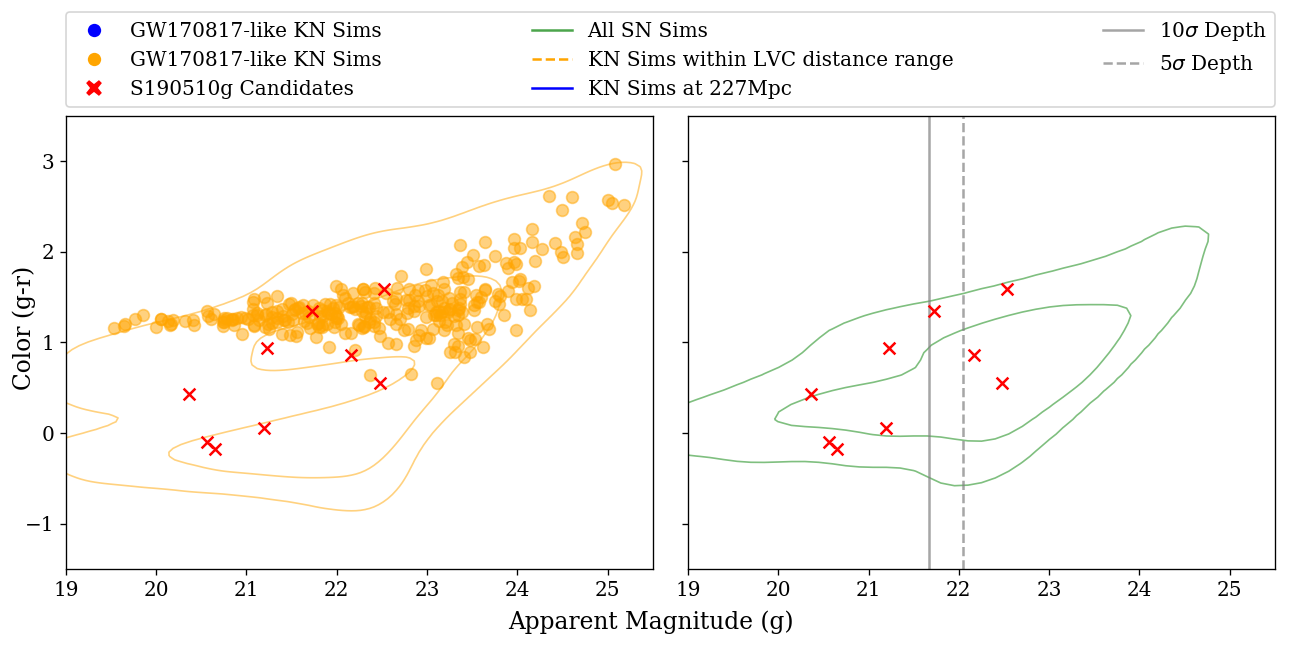

In [45]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13, 5), dpi=120)
make_contours_kde(allSNmag, allSNcol, ax[1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_g_gr['MAG'].values, KN_g_gr['COLOR'].values, ax[0], 'orange', levels=[0., 0.50, 0.90])

## plot real candidates
for data_dict in real_g_gr.values():
    col = data_dict.values()[0]
    mag = data_dict.values()[1]
    ax[0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    ax[1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    
## plot 170817 like sims
ax[0].scatter(mag170817like, color170817like, color='orange', marker='o', zorder=9, s=50, alpha=0.5)
    
# g depth lines
ax[1].axvline(x=22.05, color='gray', alpha=0.7, linestyle='--')
ax[1].axvline(x=21.67, color='gray', alpha=0.7, linestyle='-')
ax[0].axvline(x=22.05, color='gray', alpha=0.7, linestyle='--')
ax[0].axvline(x=21.67, color='gray', alpha=0.7, linestyle='-')

plt.rc('font',family='Serif')
plt.xlim(19,25.5) #20, 25.5
plt.ylim(-1.5,3.5)
fig.text(0.5, 0.025, 'Apparent Magnitude (g)', ha='center', size=14)
fig.text(0.098, 0.6, 'Color (g-r)', ha='center', size=14, rotation=90)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='X', color='w', markerfacecolor='r', label='S190510g Candidates', markersize=11),
                   #Patch(facecolor='b', alpha=0.2, label='All KN Sims'),
                  #Patch(facecolor='g', alpha=0.2, label='All SN Sims'),
                   Line2D([0], [0], ls='-', color='g', alpha=0.7, markerfacecolor='b', label='All SN Sims', markersize=9),
                  Line2D([0], [0], ls='--', color='orange', alpha=1.0, markerfacecolor='b', label='KN Sims within LVC distance range', markersize=9), 
                   Line2D([0], [0], ls='-', color='b', alpha=1.0, markerfacecolor='b', label='KN Sims at 227Mpc', markersize=9),
                  Line2D([0], [0], color='gray', alpha=0.7, markerfacecolor='b', label='10$\sigma$ Depth', markersize=9),
                  Line2D([0], [0], ls='--', color='gray', alpha=0.7, markerfacecolor='b', label='5$\sigma$ Depth', markersize=9)]

ax[0].legend(handles=legend_elements, bbox_to_anchor=(0.0, 1.02, 2.06, .102), ncol=3, loc='lower left', mode="expand", borderaxespad=0., fontsize=12)
plt.subplots_adjust(wspace=0.06, hspace=0)

## g vs g-z

In [9]:
Ia_g_gz = get_color_mag_data(data_Ia, 'g', 'g', 'z')
CC_g_gz = get_color_mag_data(data_CC, 'g', 'g', 'z')
KN_g_gz = get_color_mag_data(data_KN, 'g', 'g', 'z')

In [58]:
allSNmag = np.concatenate([Ia_g_gz['MAG'].values,CC_g_gz['MAG'].values])
allSNcol = np.concatenate([Ia_g_gz['COLOR'].values,CC_g_gz['COLOR'].values])

In [57]:
mag170817like, color170817like = get_170817_like(data_KN, KN_g_gz)
print len(mag170817like), len(color170817like)

305 305


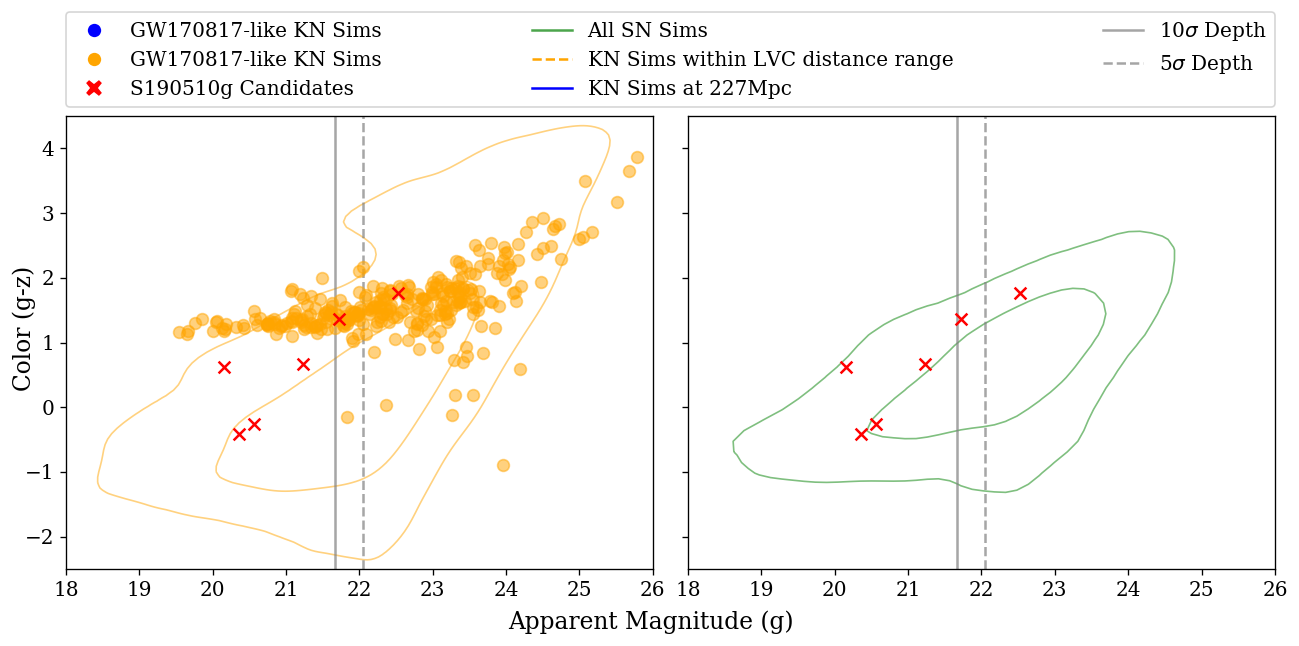

In [60]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13, 5), dpi=120)
make_contours_kde(allSNmag, allSNcol, ax[1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_g_gz['MAG'].values, KN_g_gz['COLOR'].values, ax[0], 'orange', levels=[0., 0.50, 0.90])

## plot real data
col,mag = [],[]
for data_dict in real_g_gz.values():
    col.append(data_dict.values()[0])
    mag.append(data_dict.values()[1])
ax[0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
ax[1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)

## plot 170817 like sims
ax[0].scatter(mag170817like, color170817like, color='orange', marker='o', zorder=9, s=50, alpha=0.5)

# g depth lines
ax[1].axvline(x=22.05, color='gray', alpha=0.7, linestyle='--')
ax[1].axvline(x=21.67, color='gray', alpha=0.7, linestyle='-')
ax[0].axvline(x=22.05, color='gray', alpha=0.7, linestyle='--')
ax[0].axvline(x=21.67, color='gray', alpha=0.7, linestyle='-')

plt.rc('font',family='Serif')
plt.xlim(18,26) #20, 25.5
plt.ylim(-2.5,4.5)
fig.text(0.5, 0.025, 'Apparent Magnitude (g)', ha='center', size=14)
fig.text(0.098, 0.6, 'Color (g-z)', ha='center', size=14, rotation=90)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='X', color='w', markerfacecolor='r', label='S190510g Candidates', markersize=11),
                   #Patch(facecolor='b', alpha=0.2, label='All KN Sims'),
                  #Patch(facecolor='g', alpha=0.2, label='All SN Sims'),
                   Line2D([0], [0], ls='-', color='g', alpha=0.7, markerfacecolor='b', label='All SN Sims', markersize=9),
                  Line2D([0], [0], ls='--', color='orange', alpha=1.0, markerfacecolor='b', label='KN Sims within LVC distance range', markersize=9), 
                   Line2D([0], [0], ls='-', color='b', alpha=1.0, markerfacecolor='b', label='KN Sims at 227Mpc', markersize=9),
                  Line2D([0], [0], color='gray', alpha=0.7, markerfacecolor='b', label='10$\sigma$ Depth', markersize=9),
                  Line2D([0], [0], ls='--', color='gray', alpha=0.7, markerfacecolor='b', label='5$\sigma$ Depth', markersize=9)]

ax[0].legend(handles=legend_elements, bbox_to_anchor=(0.0, 1.02, 2.06, .102), ncol=3, loc='lower left', mode="expand", borderaxespad=0., fontsize=12)
plt.subplots_adjust(wspace=0.06, hspace=0)

## r vs r-z

In [10]:
Ia_r_rz = get_color_mag_data(data_Ia, 'r', 'r', 'z')
CC_r_rz = get_color_mag_data(data_CC, 'r', 'r', 'z')
KN_r_rz = get_color_mag_data(data_KN, 'r', 'r', 'z')

In [51]:
allSNmag = np.concatenate([Ia_r_rz['MAG'].values,CC_r_rz['MAG'].values])
allSNcol = np.concatenate([Ia_r_rz['COLOR'].values,CC_r_rz['COLOR'].values])

In [52]:
mag170817like, color170817like = get_170817_like(data_KN, KN_r_rz)
print len(mag170817like), len(color170817like)

313 313


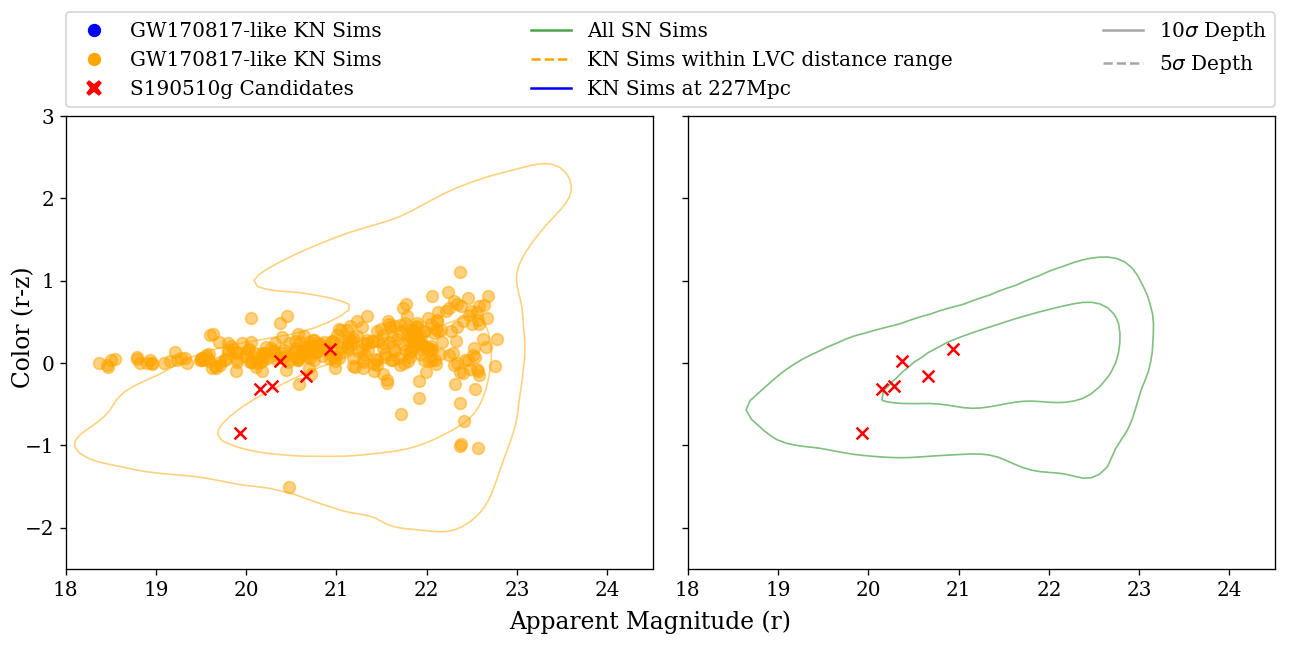

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharex=True, sharey=True, figsize=(13, 5), dpi=120)

make_contours_kde(allSNmag, allSNcol, ax[1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_r_rz['MAG'].values, KN_r_rz['COLOR'].values, ax[0], 'orange', levels=[0., 0.50, 0.90])

## plot real candidates 
for data_dict in real_r_rz.values():
    col = data_dict.values()[0]
    mag = data_dict.values()[1]
    ax[0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    ax[1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    
## plot 170817 like sims
ax[0].scatter(mag170817like, color170817like, color='orange', marker='o', zorder=9, s=50, alpha=0.5)
    
## g depth lines
#ax[1].axvline(x=22.05, color='gray', alpha=0.7, linestyle='--')
ax[1].axvline(x=21.72, color='gray', alpha=0.7, linestyle='-')

## prep figure
plt.rc('font',family='Serif')
plt.xlim(18,24.5) #20, 25.5
plt.ylim(-2.5,3)
fig.text(0.5, 0.025, 'Apparent Magnitude (r)', ha='center', size=14)
fig.text(0.098, 0.6, 'Color (r-z)', ha='center', size=14, rotation=90)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].tick_params(axis='both', labelsize=12)

## create legend
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='X', color='w', markerfacecolor='r', label='S190510g Candidates', markersize=11),
                   #Patch(facecolor='b', alpha=0.2, label='All KN Sims'),
                  #Patch(facecolor='g', alpha=0.2, label='All SN Sims'),
                   Line2D([0], [0], ls='-', color='g', alpha=0.7, markerfacecolor='b', label='All SN Sims', markersize=9),
                  Line2D([0], [0], ls='--', color='orange', alpha=1.0, markerfacecolor='b', label='KN Sims within LVC distance range', markersize=9), 
                   Line2D([0], [0], ls='-', color='b', alpha=1.0, markerfacecolor='b', label='KN Sims at 227Mpc', markersize=9),
                  Line2D([0], [0], color='gray', alpha=0.7, markerfacecolor='b', label='10$\sigma$ Depth', markersize=9),
                  Line2D([0], [0], ls='--', color='gray', alpha=0.7, markerfacecolor='b', label='5$\sigma$ Depth', markersize=9)]

ax[0].legend(handles=legend_elements, bbox_to_anchor=(0.0, 1.02, 2.06, .102), ncol=3, loc='lower left', mode="expand", borderaxespad=0., fontsize=12)
plt.subplots_adjust(wspace=0.06, hspace=0)

# Make combined plot

In [11]:
allSNmag_gr = np.concatenate([Ia_g_gr['MAG'].values,CC_g_gr['MAG'].values])
allSNcol_gr = np.concatenate([Ia_g_gr['COLOR'].values,CC_g_gr['COLOR'].values])
allSNmag_gz = np.concatenate([Ia_g_gz['MAG'].values,CC_g_gz['MAG'].values])
allSNcol_gz = np.concatenate([Ia_g_gz['COLOR'].values,CC_g_gz['COLOR'].values])
allSNmag_rz = np.concatenate([Ia_r_rz['MAG'].values,CC_r_rz['MAG'].values])
allSNcol_rz = np.concatenate([Ia_r_rz['COLOR'].values,CC_r_rz['COLOR'].values])

In [12]:
mag170817like_gr, color170817like_gr = get_170817_like(data_KN, KN_g_gr)
mag170817like_gz, color170817like_gz = get_170817_like(data_KN, KN_g_gz)
mag170817like_rz, color170817like_rz = get_170817_like(data_KN, KN_r_rz)

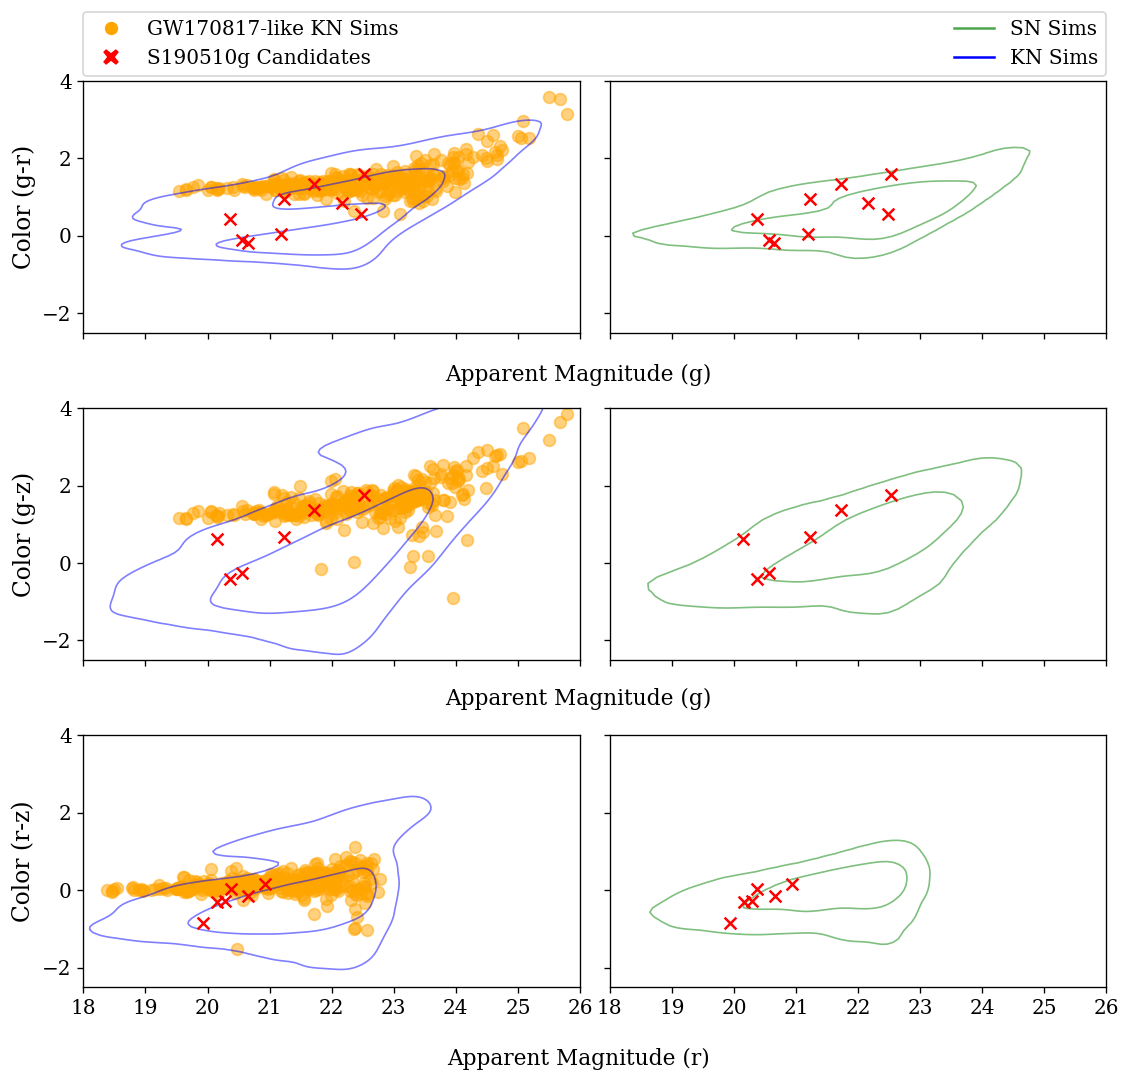

In [19]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(11, 10), dpi=120)


### plot gr ####
make_contours_kde(allSNmag_gr, allSNcol_gr, ax[0,1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_g_gr['MAG'].values, KN_g_gr['COLOR'].values, ax[0,0], 'blue', levels=[0., 0.50, 0.90])

## plot real candidates
for data_dict in real_g_gr.values():
    col = data_dict.values()[0]
    mag = data_dict.values()[1]
    ax[0,0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    ax[0,1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    
## plot 170817 like sims
ax[0,0].scatter(mag170817like_gr, color170817like_gr, color='orange', marker='o', zorder=1, s=50, alpha=0.5)
########



### plot gz ###
make_contours_kde(allSNmag_gz, allSNcol_gz, ax[1,1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_g_gz['MAG'].values, KN_g_gz['COLOR'].values, ax[1,0], 'blue', levels=[0., 0.50, 0.90])

## plot real data
col,mag = [],[]
for data_dict in real_g_gz.values():
    col.append(data_dict.values()[0])
    mag.append(data_dict.values()[1])
ax[1,0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
ax[1,1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)

## plot 170817 like sims
ax[1,0].scatter(mag170817like_gz, color170817like_gz, color='orange', marker='o', zorder=1, s=50, alpha=0.5)
#########


### plot rz ###
make_contours_kde(allSNmag_rz, allSNcol_rz, ax[2,1], 'g', levels=[0., 0.50, 0.90])
make_contours_kde(KN_r_rz['MAG'].values, KN_r_rz['COLOR'].values, ax[2,0], 'blue', levels=[0., 0.50, 0.90])

## plot real candidates 
for data_dict in real_r_rz.values():
    col = data_dict.values()[0]
    mag = data_dict.values()[1]
    ax[2,0].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    ax[2,1].scatter(mag,col, color='red', marker='x', zorder=10, s=50)
    
## plot 170817 like sims
ax[2,0].scatter(mag170817like_rz, color170817like_rz, color='orange', marker='o', zorder=1, s=50, alpha=0.5)
########

## prep figure
plt.rc('font',family='Serif')
plt.xlim(18,26) #20, 25.5
plt.ylim(-2.5,4.0)
#fig.text(0.5, 0.025, 'Apparent Magnitude (r)', ha='center', size=14)
#fig.text(0.098, 0.6, 'Color (r-z)', ha='center', size=14, rotation=90)

ax[0,0].set_ylabel('Color (g-r)', size=14)
ax[1,0].set_ylabel('Color (g-z)', size=14)
ax[2,0].set_ylabel('Color (r-z)', size=14)
fig.text(0.5, 0.63, 'Apparent Magnitude (g)', ha='center', size=13)
fig.text(0.5, 0.36, 'Apparent Magnitude (g)', ha='center', size=13)
fig.text(0.5, 0.06, 'Apparent Magnitude (r)', ha='center', size=13)

ax[0,0].tick_params(axis='both', labelsize=12)
ax[1,0].tick_params(axis='both', labelsize=12)
ax[2,0].tick_params(axis='both', labelsize=12)
ax[2,1].tick_params(axis='both', labelsize=12)
ax[2,0].tick_params(axis='both', labelsize=12)


## create legend
legend_elements = [#Line2D([0], [0], marker='o', color='w', markerfacecolor='b', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', label='GW170817-like KN Sims', markersize=9),
                   Line2D([0], [0], marker='X', color='w', markerfacecolor='r', label='S190510g Candidates', markersize=11),
                   #Patch(facecolor='b', alpha=0.2, label='All KN Sims'),
                  #Patch(facecolor='g', alpha=0.2, label='All SN Sims'),
                   Line2D([0], [0], ls='-', color='g', alpha=0.7, markerfacecolor='b', label='SN Sims', markersize=9),
                  Line2D([0], [0], ls='-', color='blue', alpha=1.0, markerfacecolor='b', label='KN Sims', markersize=9)] #, 
                   #Line2D([0], [0], ls='-', color='b', alpha=1.0, markerfacecolor='b', label='KN Sims at 227Mpc', markersize=9)] #,
                  #Line2D([0], [0], color='gray', alpha=0.7, markerfacecolor='b', label='10$\sigma$ Depth', markersize=9),
                  #Line2D([0], [0], ls='--', color='gray', alpha=0.7, markerfacecolor='b', label='5$\sigma$ Depth', markersize=9)]

ax[0,0].legend(handles=legend_elements, bbox_to_anchor=(0.0, 1.02, 2.06, .102), ncol=2, loc='lower left', mode="expand", borderaxespad=0., fontsize=12)
plt.subplots_adjust(wspace=0.06, hspace=0.3)
plt.savefig("ColorMagg_AllColors_gw190510_snr5_200331.png", bbox_inches='tight')
